#Image Filtering and Hybrid Images

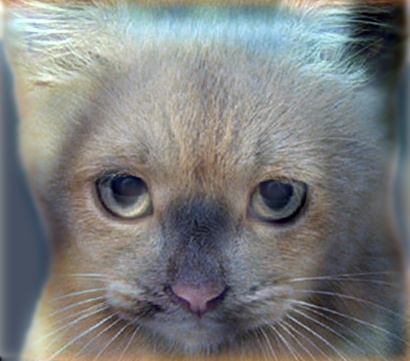

Look at the image from very close, then from far away.

##Introduction

We will learn how to create hybrid images in this project. A hybrid image is an image that is perceived differently depending on viewing distance, based on the way humans process visual input. The basic idea is that high frequency image content tends to dominate perception, but, at a distance, only the low frequency (smooth) part of the image can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, we can create a hybrid image that leads to different interpretations at different distances.


In this tutorial, we will cover:

* Basic Python: Basic data types (Containers, Lists, Dictionaries, Sets, Tuples), Functions, Classes
* Numpy: Arrays, Array indexing, Datatypes, Array math, Broadcasting
* Matplotlib: Plotting, Subplots, Images
* IPython: Creating notebooks, Typical workflows

## A Brief Note on Python Versions

You can check your Python version at the command line by running `python --version`. In Colab, we can enforce the Python version by clicking `Runtime -> Change Runtime Type` and selecting `python3`. Note that as of July 2025, Colab uses Python 3.11.13 which should run everything without any errors.

In [ ]:
!python --version

Python 3.6.9


##Basics of Python

Python is a high-level, dynamically typed multiparadigm programming language. Python code is often said to be almost like pseudocode, since it allows you to express very powerful ideas in very few lines of code while being very readable. As an example, here is an implementation of the classic quicksort algorithm in Python:

In [ ]:
def quicksort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quicksort(left) + middle + quicksort(right)

print(quicksort([3,6,8,10,1,2,1]))

[1, 1, 2, 3, 6, 8, 10]


###Basic data types

####Numbers

Integers and floats work as you would expect from other languages:

In [ ]:
x = 3
print(x, type(x))

3 <class 'int'>
ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [ ]:
print(x + 1)   # Addition
print(x - 1)   # Subtraction
print(x * 2)   # Multiplication
print(x ** 2)  # Exponentiation

4
2
6
9


In [ ]:
x += 1
print(x)
x *= 2
print(x)

9
18


In [ ]:
y = 2.5
print(type(y))
print(y, y + 1, y * 2, y ** 2)

<class 'float'>
2.5 3.5 5.0 6.25


Note that unlike many languages, Python does not have unary increment (x++) or decrement (x--) operators.

Python also has built-in types for long integers and complex numbers; you can find all of the details in the [documentation](https://docs.python.org/3.7/library/stdtypes.html#numeric-types-int-float-long-complex).

####Booleans

Python implements all of the usual operators for Boolean logic, but uses English words rather than symbols (`&&`, `||`, etc.):

In [ ]:
t, f = True, False
print(type(t))

<class 'bool'>


Now we let's look at the operations:

In [ ]:
print(t and f) # Logical AND;
print(t or f)  # Logical OR;
print(not t)   # Logical NOT;
print(t != f)  # Logical XOR;

False
True
False
True


####Strings

In [ ]:
hello = 'hello'   # String literals can use single quotes
world = "world"   # or double quotes; it does not matter
print(hello, len(hello))

hello 5


In [ ]:
hw = hello + ' ' + world  # String concatenation
print(hw)

hello world


In [ ]:
hw12 = '{} {} {}'.format(hello, world, 12)  # string formatting
print(hw12)

hello world 12


String objects have a bunch of useful methods; for example:

In [ ]:
s = "hello"
print(s.capitalize())  # Capitalize a string
print(s.upper())       # Convert a string to uppercase; prints "HELLO"
print(s.rjust(7))      # Right-justify a string, padding with spaces
print(s.center(7))     # Center a string, padding with spaces
print(s.replace('l', '(ell)'))  # Replace all instances of one substring with another
print('  world '.strip())  # Strip leading and trailing whitespace

Hello
HELLO
  hello
 hello 
he(ell)(ell)o
world


You can find a list of all string methods in the [documentation](https://docs.python.org/3.7/library/stdtypes.html#string-methods).

###Containers

Python includes several built-in container types: lists, dictionaries, sets, and tuples.

####Lists

A list is the Python equivalent of an array, but is resizeable and can contain elements of different types:

In [ ]:
xs = [3, 1, 2]   # Create a list
print(xs, xs[2])
print(xs[-1])     # Negative indices count from the end of the list; prints "2"

[3, 1, 2] 2
2


In [ ]:
xs[2] = 'foo'    # Lists can contain elements of different types
print(xs)

[3, 1, 'foo']


In [ ]:
xs.append('bar') # Add a new element to the end of the list
print(xs)

[3, 1, 'foo', 'bar']


In [ ]:
x = xs.pop()     # Remove and return the last element of the list
print(x, xs)

bar [3, 1, 'foo']


As usual, you can find all the gory details about lists in the [documentation](https://docs.python.org/3.7/tutorial/datastructures.html#more-on-lists).

####Slicing

In addition to accessing list elements one at a time, Python provides concise syntax to access sublists; this is known as slicing:

In [ ]:
nums = list(range(5))    # range is a built-in function that creates a list of integers
print(nums)         # Prints "[0, 1, 2, 3, 4]"
print(nums[2:4])    # Get a slice from index 2 to 4 (exclusive); prints "[2, 3]"
print(nums[2:])     # Get a slice from index 2 to the end; prints "[2, 3, 4]"
print(nums[:2])     # Get a slice from the start to index 2 (exclusive); prints "[0, 1]"
print(nums[:])      # Get a slice of the whole list; prints ["0, 1, 2, 3, 4]"
print(nums[:-1])    # Slice indices can be negative; prints ["0, 1, 2, 3]"
nums[2:4] = [8, 9] # Assign a new sublist to a slice
print(nums)         # Prints "[0, 1, 8, 9, 4]"

[0, 1, 2, 3, 4]
[2, 3]
[2, 3, 4]
[0, 1]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]
[0, 1, 8, 9, 4]


####Loops

You can loop over the elements of a list like this:

In [ ]:
animals = ['cat', 'dog', 'monkey']
for animal in animals:
    print(animal)

cat
dog
monkey


If you want access to the index of each element within the body of a loop, use the built-in `enumerate` function:

In [ ]:
animals = ['cat', 'dog', 'monkey']
for idx, animal in enumerate(animals):
    print('#{}: {}'.format(idx + 1, animal))

#1: cat
#2: dog
#3: monkey


####List comprehensions:

When programming, frequently we want to transform one type of data into another. As a simple example, consider the following code that computes square numbers:

In [ ]:
nums = [0, 1, 2, 3, 4]
squares = []
for x in nums:
    squares.append(x ** 2)
print(squares)

[0, 1, 4, 9, 16]


You can make this code simpler using a list comprehension:

In [ ]:
nums = [0, 1, 2, 3, 4]
squares = [x ** 2 for x in nums]
print(squares)

[0, 1, 4, 9, 16]


List comprehensions can also contain conditions:

In [ ]:
nums = [0, 1, 2, 3, 4]
even_squares = [x ** 2 for x in nums if x % 2 == 0]
print(even_squares)

[0, 4, 16]


####Dictionaries

A dictionary stores (key, value) pairs, similar to a `Map` in Java or an object in Javascript. You can use it like this:

In [ ]:
d = {'cat': 'cute', 'dog': 'furry'}  # Create a new dictionary with some data
print(d['cat'])       # Get an entry from a dictionary; prints "cute"
print('cat' in d)     # Check if a dictionary has a given key; prints "True"

cute
True


In [ ]:
d['fish'] = 'wet'    # Set an entry in a dictionary
print(d['fish'])      # Prints "wet"

wet


In [ ]:
print(d['monkey'])  # KeyError: 'monkey' not a key of d

KeyError: ignored

In [ ]:
print(d.get('monkey', 'N/A'))  # Get an element with a default; prints "N/A"
print(d.get('fish', 'N/A'))    # Get an element with a default; prints "wet"

N/A
wet


In [ ]:
del d['fish']        # Remove an element from a dictionary
print(d.get('fish', 'N/A')) # "fish" is no longer a key; prints "N/A"

N/A


You can find all you need to know about dictionaries in the [documentation](https://docs.python.org/2/library/stdtypes.html#dict).

It is easy to iterate over the keys in a dictionary:

In [ ]:
d = {'person': 2, 'cat': 4, 'spider': 8}
for animal, legs in d.items():
    print('A {} has {} legs'.format(animal, legs))

A person has 2 legs
A cat has 4 legs
A spider has 8 legs


Dictionary comprehensions: These are similar to list comprehensions, but allow you to easily construct dictionaries. For example:

In [ ]:
nums = [0, 1, 2, 3, 4]
even_num_to_square = {x: x ** 2 for x in nums if x % 2 == 0}
print(even_num_to_square)

{0: 0, 2: 4, 4: 16}


####Sets

A set is an unordered collection of distinct elements. As a simple example, consider the following:

In [ ]:
animals = {'cat', 'dog'}
print('cat' in animals)   # Check if an element is in a set; prints "True"
print('fish' in animals)  # prints "False"


True
False


In [ ]:
animals.add('fish')      # Add an element to a set
print('fish' in animals)
print(len(animals))       # Number of elements in a set;

True
3


In [ ]:
animals.add('cat')       # Adding an element that is already in the set does nothing
print(len(animals))
animals.remove('cat')    # Remove an element from a set
print(len(animals))

3
2


_Loops_: Iterating over a set has the same syntax as iterating over a list; however since sets are unordered, you cannot make assumptions about the order in which you visit the elements of the set:

In [ ]:
animals = {'cat', 'dog', 'fish'}
for idx, animal in enumerate(animals):
    print('#{}: {}'.format(idx + 1, animal))

#1: dog
#2: cat
#3: fish


Set comprehensions: Like lists and dictionaries, we can easily construct sets using set comprehensions:

In [ ]:
from math import sqrt
print({int(sqrt(x)) for x in range(30)})

{0, 1, 2, 3, 4, 5}


####Tuples

A tuple is an (immutable) ordered list of values. A tuple is in many ways similar to a list; one of the most important differences is that tuples can be used as keys in dictionaries and as elements of sets, while lists cannot. Here is a trivial example:

In [ ]:
d = {(x, x + 1): x for x in range(10)}  # Create a dictionary with tuple keys
t = (5, 6)       # Create a tuple
print(type(t))
print(d[t])
print(d[(1, 2)])

<class 'tuple'>
5
1


In [ ]:
t[0] = 1

TypeError: ignored

###Functions

Python functions are defined using the `def` keyword. For example:

In [ ]:
def sign(x):
    if x > 0:
        return 'positive'
    elif x < 0:
        return 'negative'
    else:
        return 'zero'

for x in [-1, 0, 1]:
    print(sign(x))

negative
zero
positive


We will often define functions to take optional keyword arguments, like this:

In [ ]:
def hello(name, loud=False):
    if loud:
        print('HELLO, {}'.format(name.upper()))
    else:
        print('Hello, {}!'.format(name))

hello('Bob')
hello('Fred', loud=True)

Hello, Bob!
HELLO, FRED


###Classes

The syntax for defining classes in Python is straightforward:

In [ ]:
class Greeter:

    # Constructor
    def __init__(self, name):
        self.name = name  # Create an instance variable

    # Instance method
    def greet(self, loud=False):
        if loud:
          print('HELLO, {}'.format(self.name.upper()))
        else:
          print('Hello, {}!'.format(self.name))

g = Greeter('Fred')  # Construct an instance of the Greeter class
g.greet()            # Call an instance method; prints "Hello, Fred"
g.greet(loud=True)   # Call an instance method; prints "HELLO, FRED!"

Hello, Fred!
HELLO, FRED


##Numpy

Numpy is the core library for scientific computing in Python. It provides a high-performance multidimensional array object, and tools for working with these arrays. If you are already familiar with MATLAB, you might find this [tutorial](http://wiki.scipy.org/NumPy_for_Matlab_Users) useful to get started with Numpy.

To use Numpy, we first need to import the `numpy` package:

In [ ]:
import numpy as np

###Arrays

A numpy array is a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension.

We can initialize numpy arrays from nested Python lists, and access elements using square brackets:

In [ ]:
a = np.array([1, 2, 3])  # Create a rank 1 array
print(type(a), a.shape, a[0], a[1], a[2])
a[0] = 5                 # Change an element of the array
print(a)

<class 'numpy.ndarray'> (3,) 1 2 3
[5 2 3]


In [ ]:
b = np.array([[1,2,3],[4,5,6]])   # Create a rank 2 array
print(b)

[[1 2 3]
 [4 5 6]]


In [ ]:
print(b.shape)
print(b[0, 0], b[0, 1], b[1, 0])

(2, 3)
1 2 4


Numpy also provides many functions to create arrays:

In [ ]:
a = np.zeros((2,2))  # Create an array of all zeros
print(a)

[[0. 0.]
 [0. 0.]]


In [ ]:
b = np.ones((1,2))   # Create an array of all ones
print(b)

[[1. 1.]]


In [ ]:
c = np.full((2,2), 7) # Create a constant array
print(c)

[[7 7]
 [7 7]]


In [ ]:
d = np.eye(2)        # Create a 2x2 identity matrix
print(d)

[[1. 0.]
 [0. 1.]]


In [ ]:
e = np.random.random((2,2)) # Create an array filled with random values
print(e)

[[0.8690054  0.57244319]
 [0.29647245 0.81464494]]


###Array indexing

Numpy offers several ways to index into arrays.

Slicing: Similar to Python lists, numpy arrays can be sliced. Since arrays may be multidimensional, you must specify a slice for each dimension of the array:

In [ ]:
import numpy as np

# Create the following rank 2 array with shape (3, 4)
# [[ 1  2  3  4]
#  [ 5  6  7  8]
#  [ 9 10 11 12]]
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])

# Use slicing to pull out the subarray consisting of the first 2 rows
# and columns 1 and 2; b is the following array of shape (2, 2):
# [[2 3]
#  [6 7]]
b = a[:2, 1:3]
print(b)

[[2 3]
 [6 7]]


A slice of an array is a view into the same data, so modifying it will modify the original array.

In [ ]:
print(a[0, 1])
b[0, 0] = 77    # b[0, 0] is the same piece of data as a[0, 1]
print(a[0, 1])

2
77


You can also mix integer indexing with slice indexing. However, doing so will yield an array of lower rank than the original array. Note that this is quite different from the way that MATLAB handles array slicing:

In [ ]:
# Create the following rank 2 array with shape (3, 4)
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print(a)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


Two ways of accessing the data in the middle row of the array.
Mixing integer indexing with slices yields an array of lower rank,
while using only slices yields an array of the same rank as the
original array:

In [ ]:
row_r1 = a[1, :]    # Rank 1 view of the second row of a
row_r2 = a[1:2, :]  # Rank 2 view of the second row of a
row_r3 = a[[1], :]  # Rank 2 view of the second row of a
print(row_r1, row_r1.shape)
print(row_r2, row_r2.shape)
print(row_r3, row_r3.shape)

[5 6 7 8] (4,)
[[5 6 7 8]] (1, 4)
[[5 6 7 8]] (1, 4)


In [ ]:
# We can make the same distinction when accessing columns of an array:
col_r1 = a[:, 1]
col_r2 = a[:, 1:2]
print(col_r1, col_r1.shape)
print()
print(col_r2, col_r2.shape)

[ 2  6 10] (3,)

[[ 2]
 [ 6]
 [10]] (3, 1)


Integer array indexing: When you index into numpy arrays using slicing, the resulting array view will always be a subarray of the original array. In contrast, integer array indexing allows you to construct arbitrary arrays using the data from another array. Here is an example:

In [ ]:
a = np.array([[1,2], [3, 4], [5, 6]])

# An example of integer array indexing.
# The returned array will have shape (3,) and
print(a[[0, 1, 2], [0, 1, 0]])

# The above example of integer array indexing is equivalent to this:
print(np.array([a[0, 0], a[1, 1], a[2, 0]]))

[1 4 5]
[1 4 5]


In [ ]:
# When using integer array indexing, you can reuse the same
# element from the source array:
print(a[[0, 0], [1, 1]])

# Equivalent to the previous integer array indexing example
print(np.array([a[0, 1], a[0, 1]]))

[2 2]
[2 2]


One useful trick with integer array indexing is selecting or mutating one element from each row of a matrix:

In [ ]:
# Create a new array from which we will select elements
a = np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
print(a)

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [ ]:
# Create an array of indices
b = np.array([0, 2, 0, 1])

# Select one element from each row of a using the indices in b
print(a[np.arange(4), b])  # Prints "[ 1  6  7 11]"

[ 1  6  7 11]


In [ ]:
# Mutate one element from each row of a using the indices in b
a[np.arange(4), b] += 10
print(a)

[[11  2  3]
 [ 4  5 16]
 [17  8  9]
 [10 21 12]]


Boolean array indexing: Boolean array indexing lets you pick out arbitrary elements of an array. Frequently this type of indexing is used to select the elements of an array that satisfy some condition. Here is an example:

In [ ]:
import numpy as np

a = np.array([[1,2], [3, 4], [5, 6]])

bool_idx = (a > 2)  # Find the elements of a that are bigger than 2;
                    # this returns a numpy array of Booleans of the same
                    # shape as a, where each slot of bool_idx tells
                    # whether that element of a is > 2.

print(bool_idx)

[[False False]
 [ True  True]
 [ True  True]]


In [ ]:
# We use boolean array indexing to construct a rank 1 array
# consisting of the elements of a corresponding to the True values
# of bool_idx
print(a[bool_idx])

# We can do all of the above in a single concise statement:
print(a[a > 2])

[3 4 5 6]
[3 4 5 6]


For brevity we have left out a lot of details about numpy array indexing; if you want to know more you should read the documentation.

###Datatypes

Every numpy array is a grid of elements of the same type. Numpy provides a large set of numeric datatypes that you can use to construct arrays. Numpy tries to guess a datatype when you create an array, but functions that construct arrays usually also include an optional argument to explicitly specify the datatype. Here is an example:

In [ ]:
x = np.array([1, 2])  # Let numpy choose the datatype
y = np.array([1.0, 2.0])  # Let numpy choose the datatype
z = np.array([1, 2], dtype=np.int64)  # Force a particular datatype

print(x.dtype, y.dtype, z.dtype)

int64 float64 int64


You can read all about numpy datatypes in the [documentation](http://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html).

###Array math

Basic mathematical functions operate elementwise on arrays, and are available both as operator overloads and as functions in the numpy module:

In [ ]:
x = np.array([[1,2],[3,4]], dtype=np.float64)
y = np.array([[5,6],[7,8]], dtype=np.float64)

# Elementwise sum; both produce the array
print(x + y)
print(np.add(x, y))

[[ 6.  8.]
 [10. 12.]]
[[ 6.  8.]
 [10. 12.]]


In [ ]:
# Elementwise difference; both produce the array
print(x - y)
print(np.subtract(x, y))

[[-4. -4.]
 [-4. -4.]]
[[-4. -4.]
 [-4. -4.]]


In [ ]:
# Elementwise product; both produce the array
print(x * y)
print(np.multiply(x, y))

[[ 5. 12.]
 [21. 32.]]
[[ 5. 12.]
 [21. 32.]]


In [ ]:
# Elementwise division; both produce the array
# [[ 0.2         0.33333333]
#  [ 0.42857143  0.5       ]]
print(x / y)
print(np.divide(x, y))

[[0.2        0.33333333]
 [0.42857143 0.5       ]]
[[0.2        0.33333333]
 [0.42857143 0.5       ]]


In [ ]:
# Elementwise square root; produces the array
# [[ 1.          1.41421356]
#  [ 1.73205081  2.        ]]
print(np.sqrt(x))

[[1.         1.41421356]
 [1.73205081 2.        ]]


Note that unlike MATLAB, `*` is elementwise multiplication, not matrix multiplication. We instead use the dot function to compute inner products of vectors, to multiply a vector by a matrix, and to multiply matrices. dot is available both as a function in the numpy module and as an instance method of array objects:

In [ ]:
x = np.array([[1,2],[3,4]])
y = np.array([[5,6],[7,8]])

v = np.array([9,10])
w = np.array([11, 12])

# Inner product of vectors; both produce 219
print(v.dot(w))
print(np.dot(v, w))

219
219


You can also use the `@` operator which is equivalent to numpy's `dot` operator.

In [ ]:
print(v @ w)

219


In [ ]:
# Matrix / vector product; both produce the rank 1 array [29 67]
print(x.dot(v))
print(np.dot(x, v))
print(x @ v)

[29 67]
[29 67]
[29 67]


In [ ]:
# Matrix / matrix product; both produce the rank 2 array
# [[19 22]
#  [43 50]]
print(x.dot(y))
print(np.dot(x, y))
print(x @ y)

[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]


Numpy provides many useful functions for performing computations on arrays; one of the most useful is `sum`:

In [ ]:
x = np.array([[1,2],[3,4]])

print(np.sum(x))  # Compute sum of all elements; prints "10"
print(np.sum(x, axis=0))  # Compute sum of each column; prints "[4 6]"
print(np.sum(x, axis=1))  # Compute sum of each row; prints "[3 7]"

10
[4 6]
[3 7]


You can find the full list of mathematical functions provided by numpy in the [documentation](http://docs.scipy.org/doc/numpy/reference/routines.math.html).

Apart from computing mathematical functions using arrays, we frequently need to reshape or otherwise manipulate data in arrays. The simplest example of this type of operation is transposing a matrix; to transpose a matrix, simply use the T attribute of an array object:

In [ ]:
print(x)
print("transpose\n", x.T)

[[1 2]
 [3 4]]
transpose
 [[1 3]
 [2 4]]


In [ ]:
v = np.array([[1,2,3]])
print(v )
print("transpose\n", v.T)

[[1 2 3]]
transpose
 [[1]
 [2]
 [3]]


###Broadcasting

Broadcasting is a powerful mechanism that allows numpy to work with arrays of different shapes when performing arithmetic operations. Frequently we have a smaller array and a larger array, and we want to use the smaller array multiple times to perform some operation on the larger array.

For example, suppose that we want to add a constant vector to each row of a matrix. We could do it like this:

In [ ]:
# We will add the vector v to each row of the matrix x,
# storing the result in the matrix y
x = np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
v = np.array([1, 0, 1])
y = np.empty_like(x)   # Create an empty matrix with the same shape as x

# Add the vector v to each row of the matrix x with an explicit loop
for i in range(4):
    y[i, :] = x[i, :] + v

print(y)

[[ 2  2  4]
 [ 5  5  7]
 [ 8  8 10]
 [11 11 13]]


This works; however when the matrix `x` is very large, computing an explicit loop in Python could be slow. Note that adding the vector v to each row of the matrix `x` is equivalent to forming a matrix `vv` by stacking multiple copies of `v` vertically, then performing elementwise summation of `x` and `vv`. We could implement this approach like this:

In [ ]:
vv = np.tile(v, (4, 1))  # Stack 4 copies of v on top of each other
print(vv)                # Prints "[[1 0 1]
                         #          [1 0 1]
                         #          [1 0 1]
                         #          [1 0 1]]"

[[1 0 1]
 [1 0 1]
 [1 0 1]
 [1 0 1]]


In [ ]:
y = x + vv  # Add x and vv elementwise
print(y)

[[ 2  2  4]
 [ 5  5  7]
 [ 8  8 10]
 [11 11 13]]


Numpy broadcasting allows us to perform this computation without actually creating multiple copies of v. Consider this version, using broadcasting:

In [ ]:
import numpy as np

# We will add the vector v to each row of the matrix x,
# storing the result in the matrix y
x = np.array([[1,2,3], [4,5,6], [7,8,9], [10, 11, 12]])
v = np.array([1, 0, 1])
y = x + v  # Add v to each row of x using broadcasting
print(y)

[[ 2  2  4]
 [ 5  5  7]
 [ 8  8 10]
 [11 11 13]]


The line `y = x + v` works even though `x` has shape `(4, 3)` and `v` has shape `(3,)` due to broadcasting; this line works as if v actually had shape `(4, 3)`, where each row was a copy of `v`, and the sum was performed elementwise.

Broadcasting two arrays together follows these rules:

1. If the arrays do not have the same rank, prepend the shape of the lower rank array with 1s until both shapes have the same length.
2. The two arrays are said to be compatible in a dimension if they have the same size in the dimension, or if one of the arrays has size 1 in that dimension.
3. The arrays can be broadcast together if they are compatible in all dimensions.
4. After broadcasting, each array behaves as if it had shape equal to the elementwise maximum of shapes of the two input arrays.
5. In any dimension where one array had size 1 and the other array had size greater than 1, the first array behaves as if it were copied along that dimension

If this explanation does not make sense, try reading the explanation from the [documentation](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) or this [explanation](http://wiki.scipy.org/EricsBroadcastingDoc).

Functions that support broadcasting are known as universal functions. You can find the list of all universal functions in the [documentation](http://docs.scipy.org/doc/numpy/reference/ufuncs.html#available-ufuncs).

Here are some applications of broadcasting:

In [ ]:
# Compute outer product of vectors
v = np.array([1,2,3])  # v has shape (3,)
w = np.array([4,5])    # w has shape (2,)
# To compute an outer product, we first reshape v to be a column
# vector of shape (3, 1); we can then broadcast it against w to yield
# an output of shape (3, 2), which is the outer product of v and w:

print(np.reshape(v, (3, 1)) * w)

[[ 4  5]
 [ 8 10]
 [12 15]]


In [ ]:
# Add a vector to each row of a matrix
x = np.array([[1,2,3], [4,5,6]])
# x has shape (2, 3) and v has shape (3,) so they broadcast to (2, 3),
# giving the following matrix:

print(x + v)

[[2 4 6]
 [5 7 9]]


In [ ]:
# Add a vector to each column of a matrix
# x has shape (2, 3) and w has shape (2,).
# If we transpose x then it has shape (3, 2) and can be broadcast
# against w to yield a result of shape (3, 2); transposing this result
# yields the final result of shape (2, 3) which is the matrix x with
# the vector w added to each column. Gives the following matrix:

print((x.T + w).T)

[[ 5  6  7]
 [ 9 10 11]]


In [ ]:
# Another solution is to reshape w to be a row vector of shape (2, 1);
# we can then broadcast it directly against x to produce the same
# output.
print(x + np.reshape(w, (2, 1)))

[[ 5  6  7]
 [ 9 10 11]]


In [ ]:
# Multiply a matrix by a constant:
# x has shape (2, 3). Numpy treats scalars as arrays of shape ();
# these can be broadcast together to shape (2, 3), producing the
# following array:
print(x * 2)

[[ 2  4  6]
 [ 8 10 12]]


Broadcasting typically makes your code more concise and faster, so you should strive to use it where possible.

This brief overview has touched on many of the important things that you need to know about numpy, but is far from complete. Check out the [numpy reference](http://docs.scipy.org/doc/numpy/reference/) to find out much more about numpy.

##Matplotlib

Matplotlib is a plotting library. In this section give a brief introduction to the `matplotlib.pyplot` module, which provides a plotting system similar to that of MATLAB.

In [ ]:
import matplotlib.pyplot as plt

By running this special iPython command, we will be displaying plots inline:

In [ ]:
%matplotlib inline

###Plotting

The most important function in `matplotlib` is plot, which allows you to plot 2D data. Here is a simple example:

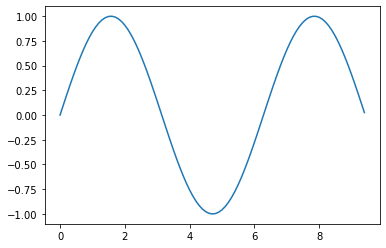

In [ ]:
# Compute the x and y coordinates for points on a sine curve
x = np.arange(0, 3 * np.pi, 0.1)
y = np.sin(x)

# Plot the points using matplotlib
plt.plot(x, y)

With just a little bit of extra work we can easily plot multiple lines at once, and add a title, legend, and axis labels:

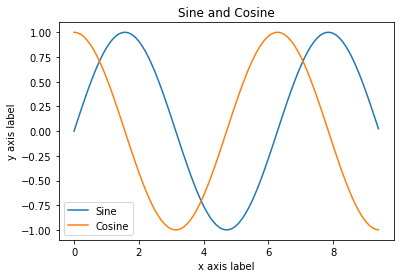

In [ ]:
y_sin = np.sin(x)
y_cos = np.cos(x)

# Plot the points using matplotlib
plt.plot(x, y_sin)
plt.plot(x, y_cos)
plt.xlabel('x axis label')
plt.ylabel('y axis label')
plt.title('Sine and Cosine')
plt.legend(['Sine', 'Cosine'])

###Subplots

You can plot different things in the same figure using the subplot function. Here is an example:

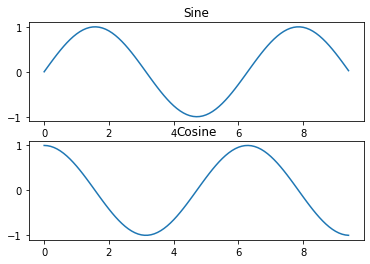

In [ ]:
# Compute the x and y coordinates for points on sine and cosine curves
x = np.arange(0, 3 * np.pi, 0.1)
y_sin = np.sin(x)
y_cos = np.cos(x)

# Set up a subplot grid that has height 2 and width 1,
# and set the first such subplot as active.
plt.subplot(2, 1, 1)

# Make the first plot
plt.plot(x, y_sin)
plt.title('Sine')

# Set the second subplot as active, and make the second plot.
plt.subplot(2, 1, 2)
plt.plot(x, y_cos)
plt.title('Cosine')

# Show the figure.
plt.show()

You can read much more about the `subplot` function in the [documentation](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot).